In [1]:
import pandas as pd
import random
import numpy as np

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def init_random():
    random.seed(0)
    np.random.seed(0)

init_random()

In [4]:
dataset = pd.read_csv('dataset_191_wine.csv')
dataset

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280%2FOD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


Нам повезло, что все признаки уже численные, и их к числам приводить не надо. Осталось только провести нормализацию, потому что все критерии имеют слишком разный вклад в расстояние

In [5]:
X, y = dataset.drop(columns=['class']).to_numpy(), dataset['class'].to_numpy()
X.shape, y.shape

((178, 13), (178,))

In [6]:
Xn = (X - X.mean(axis=0)) / X.std(axis=0)

# Сделаем реализацию DBSCAN

In [7]:
from collections import deque

def adjacency_matrix(dist, x, print_stat=False):
    n = x.shape[0]
    matrix = [[0 for _ in range(n)] for _ in range(n)]
    total_min = float('+inf')
    for i in range(n):
        for j in range(n):
            matrix[i][j] = dist(x[i], x[j])
            if i != j:
                total_min = min(matrix[i][j], total_min)
    if print_stat:
        print(f'Distances: from {total_min} to {np.max(matrix)} (avg {np.mean(matrix)})')
    return matrix

class DBSCAN:
    def __init__(self, eps, core_limit, dist):
        self.eps = eps
        self.core_limit = core_limit
        self.dist = dist
        self.x = None
        self.labels = None
        self.matrix = None

    def __range_query(self, s):
        neighbors = []
        for i in range(self.x.shape[0]):
            if self.matrix[s][i] < self.eps:
                neighbors.append(i)
        return neighbors

    def cluster(self, x):
        self.x = x
        self.labels = np.full((x.shape[0], ), -1)
        self.matrix = adjacency_matrix(self.dist, x)
        n, cnt = x.shape[0], 0
        
        indices = list(range(n))
        np.random.shuffle(indices)
        for s in indices:
            if self.labels[s] > 0:
                continue
            neighbors = self.__range_query(s)
            if len(neighbors) < self.core_limit:
                self.labels[s] = 0
                continue
            cnt = cnt + 1
            self.labels[s] = cnt
            d = deque(neighbors)
            while len(d) > 0:
                r = d.popleft()
                if self.labels[r] > -1:
                    if self.labels[r] == 0:
                        self.labels[r] = cnt
                    continue
                self.labels[r] = cnt
                neighbors_next = self.__range_query(r)
                if len(neighbors_next) >= self.core_limit:
                    d.extend(neighbors_next)
        
        self.n_classes = cnt
        return self.labels

# Сделаем реализации функций расстояния и метрик

In [8]:
def euclidean(x1, x2):
    return np.linalg.norm(x1 - x2)

def manhattan(x1, x2):
    return np.abs(x1 - x2).sum()

def cosine(x1, x2):
    return (x1 * x2).sum() / np.linalg.norm(x1) / np.linalg.norm(x2)

In [9]:
for f in [euclidean, manhattan, cosine]:
    _ = adjacency_matrix(f, Xn, print_stat=True)

Distances: from 1.1641136694837706 to 11.211496062171108 (avg 4.878726982073548)
Distances: from 3.1959601579472245 to 32.001170352522635 (avg 14.548867679991323)
Distances: from -0.9182612173087576 to 1.0000000000000002 (avg 0.0018604140196983488)


In [10]:
def stats(model, y):
    n = model.x.shape[0]
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(n):
        for j in range(n):
            if model.labels[i] * model.labels[j] == 0 or model.labels[i] != model.labels[j]:
                if y[i] == y[j]:
                    fp += 1
                else:
                    tn += 1
            else:
                if y[i] == y[j]:
                    tp += 1
                else:
                    fn += 1
    return tp, tn, fp, fn

def rand_index(model, y):
    tp, tn, fp, fn = stats(model, y)
    return (tp + tn) / (tp + tn + fp + fn)

def calinski_harabaz_index(model):
    n = model.x.shape[0]
    global_c = model.x.mean(axis=0)
    classes = [[] for i in range(model.n_classes + 1)]
    for i in range(n):
        classes[model.labels[i]].append(i)
    
    cls = range(len(classes))
    local_c = [model.x[classes[c]].mean(axis=0) if len(classes[c]) > 0 else global_c for c in cls]
    numerator = sum([len(classes[c]) * np.linalg.norm(local_c[c] - global_c) for c in cls])
    denominator = sum([np.linalg.norm(model.x[i] - local_c[model.labels[i]]) for i in range(n)])

    return numerator / denominator * (n - len(cls) - 1) / len(cls)

# Запустим DBSCAN

In [11]:
model = DBSCAN(2.0, 3, euclidean)
y_pred = model.cluster(Xn)
print(model.n_classes)
print(y_pred)

5
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0
 1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 5 5 5 3 3 0 0 3 4 4 0 4 3 0 5 0 3
 3 2 2 2 0 3 3 3 3 0 0 0 3 4 4 5 3 3 3 3 3 0 5 3 3 3 3 2 2 0]


Попробуем перебрать параметры

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars
6it [08:38, 86.37s/it]


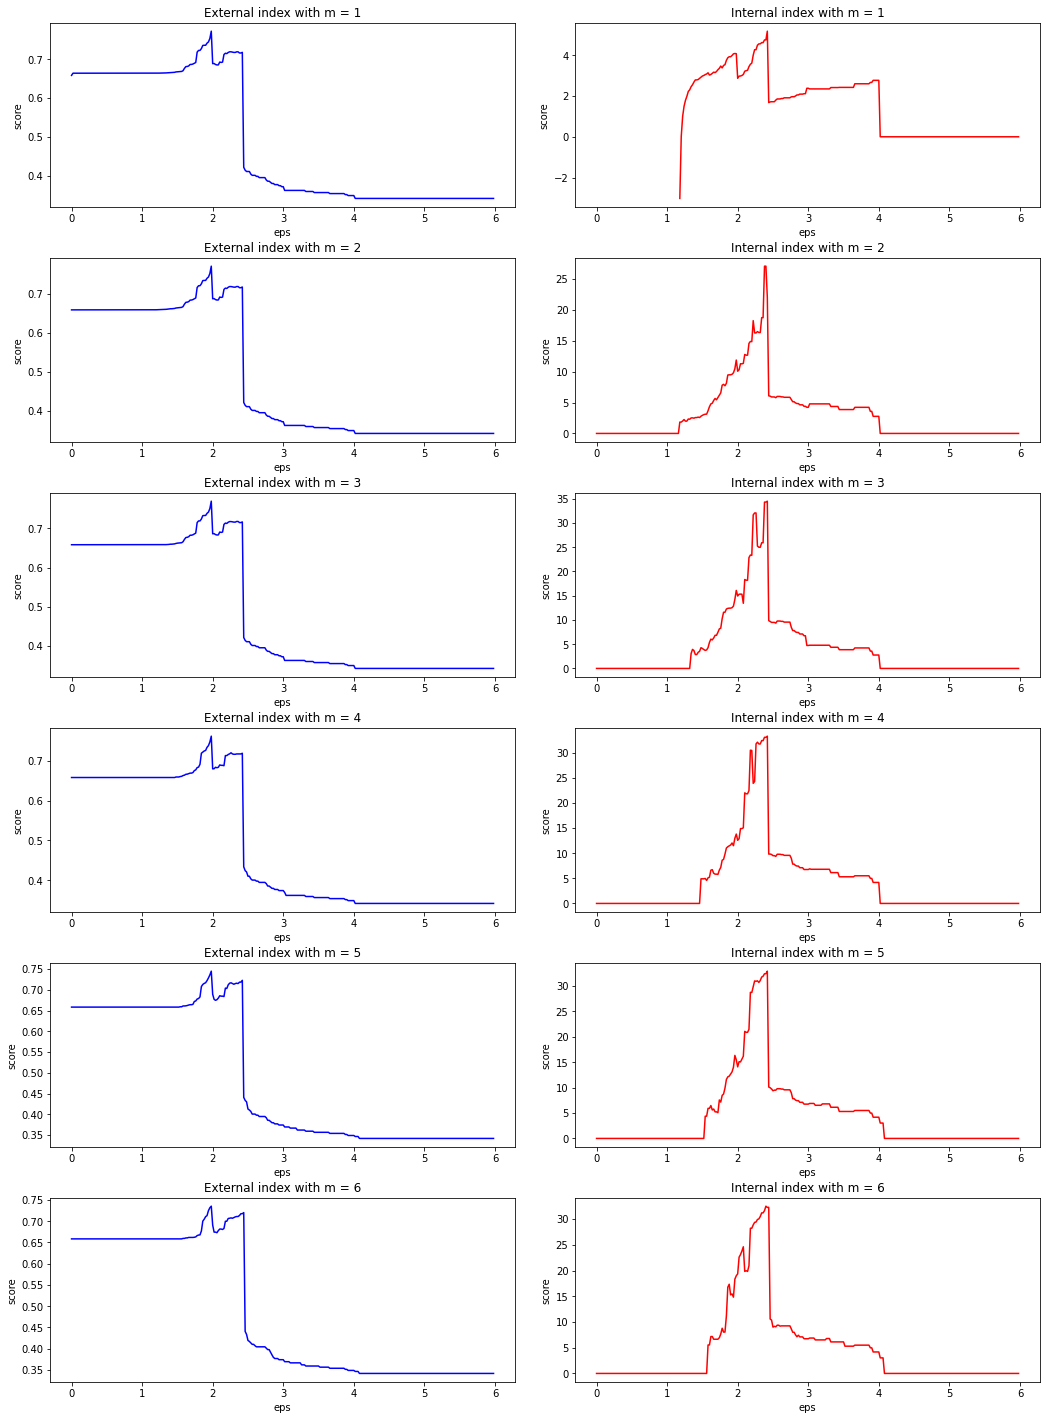

In [30]:
from tqdm import tqdm

epss = np.arange(0, 6, 0.02)
mins = np.arange(1, 7)
opt_mins = [(-1, -1) for _ in range(len(epss))]
with_3c_opt_mins = [(-1, -1) for _ in range(len(epss))]

f, ax = plt.subplots(len(mins), 2, figsize=(15, 20))
f.tight_layout(pad=3.0)
for j, m in tqdm(enumerate(mins)):
    ext_scores = []
    int_scores = []
    for i, eps in enumerate(epss):
        model = DBSCAN(eps, m, euclidean)
        model.cluster(Xn)
        ext_scores.append(rand_index(model, y))
        int_scores.append(calinski_harabaz_index(model))

        if 15 * ext_scores[-1] + int_scores[-1] > opt_mins[i][0]:
            opt_mins[i] = (15 * ext_scores[-1] + int_scores[-1], m)
        if 15 * ext_scores[-1] + int_scores[-1] > with_3c_opt_mins[i][0] and model.n_classes == 3:
            with_3c_opt_mins[i] = (15 * ext_scores[-1] + int_scores[-1], m)
    
    for t in range(2):
        ax[j, t].set_xlabel('eps')
        ax[j, t].set_ylabel('score')
    ax[j, 0].plot(epss, ext_scores, c='b', label='external index')
    ax[j, 1].plot(epss, int_scores, c='r', label='internal index')
    ax[j, 0].set_title(f'External index with m = {m}')
    ax[j, 1].set_title(f'Internal index with m = {m}')

In [31]:
def best(opts):
    opt_eps, opt_m, score = -1, -1, -1
    for i, eps in enumerate(epss):
        if opts[i][0] > score:
            score = opts[i][0]
            opt_m = opts[i][1]
            opt_eps = eps
    return opt_eps, opt_m, score

opt_eps, opt_m, score = best(opt_mins)
opt_eps_3, opt_m_3, score_3 = best(with_3c_opt_mins)
print(opt_eps, opt_m, score)
print(opt_eps_3, opt_m_3, score_3)

2.42 3 45.25390489351315
2.38 2 37.81538929765226


In [32]:
from sklearn.decomposition import PCA

def pca(x, k):
    return PCA(n_components=k).fit_transform(x)
    # ? unused ?
    cov = np.cov(x.T)
    ev, eig = np.linalg.eig(cov)
    idx = ev.argsort()[::-1]
    ev = ev[idx]
    eig = eig[:,idx]
    return x.dot(eig[:, :k])

colors = ['yellow', 'purple', 'aquamarine', 'grey']

def plot_scatter(plot, title, x, transform, labels):
    xp = transform(x)
    plot.set_title(title)
    plot.scatter(xp[:, 0], xp[:, 1], c=list(map(lambda i: colors[i - 1], labels)))

def two_scatters(title, x, labels):
    f, ax = plt.subplots(1, 2, figsize=(15, 5))
    plot_scatter(ax[0], f'{title} (pca)', x, lambda d: pca(d, 2), labels)
    plot_scatter(ax[1], f'{title} (proj)', x, lambda d: d, labels)

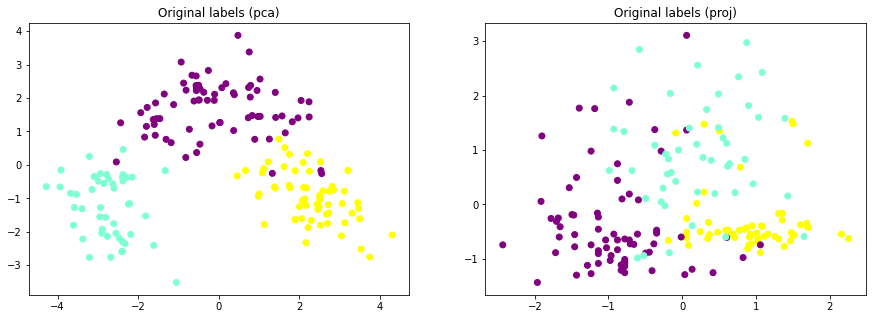

In [33]:
two_scatters('Original labels', Xn, y)

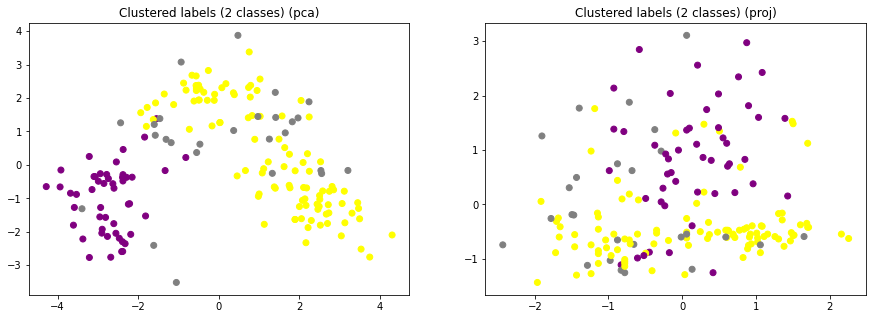

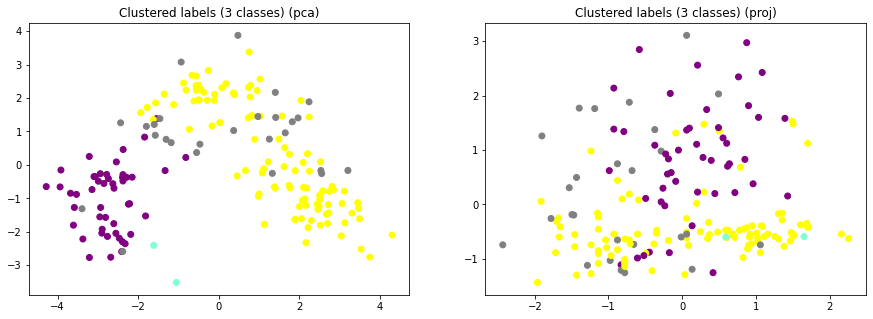

In [34]:
model2 = DBSCAN(opt_eps, opt_m, euclidean)
model3 = DBSCAN(opt_eps_3, opt_m_3, euclidean)
for model in [model2, model3]:
    _ = model.cluster(Xn)
    two_scatters(f'Clustered labels ({model.n_classes} classes)', Xn, model.labels)